# Identify fraud from Eron Email

## Context 

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

### The Dataset

As preprocessing to this project, we've combined the Enron email and financial data into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

POI label: [‘poi’] (boolean, represented as integer)

### Understanding the Dataset and Question

- Data Exploration (related lesson: "Datasets and Questions"):

Student response addresses the most important characteristics of the dataset and uses these characteristics to inform their analysis. Important characteristics include:
 total number of data points, 
 allocation across classes (POI/non-POI), 
 number of features used, 
 are there features with many missing values?,etc

- Outlier Investigation (related lesson: "Outliers"):
Student response identifies outlier(s) in the financial data, and explains how they are removed or otherwise handled.


### Libraries

In this project I will use the libraries sys, pickle, pandas, numpy, matplot and pprint and the external file tester.

I will use pickle to load the data; pandas and numpy to data manipulation, matplot to plot our visualizations and tester to test our model.

In [1]:
import sys
import pickle 
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import tester

%matplotlib inline
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit

/Users/andreyai/anaconda/envs/bunnies/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Importing Dataset

I will import the dataset that is in a final_project_dataset.pkl file.

In [2]:
# Importing Dataset
data_dict = pickle.load(open("../final_project/final_project_dataset.pkl", "r") )

### Data Exploration
In this part I will perform initial data analysis. 
First, we will see a instance of this data in order to get a sense of the data features.

In [3]:
data_dict.values()[0]

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

There are 21 features some are financial features and others are email features. We can also see that we will need to handle with the NaN values. Let see the features.

In [4]:
len(data_dict.values()[0].keys()),data_dict.values()[0].keys()

(21,
 ['salary',
  'to_messages',
  'deferral_payments',
  'total_payments',
  'exercised_stock_options',
  'bonus',
  'restricted_stock',
  'shared_receipt_with_poi',
  'restricted_stock_deferred',
  'total_stock_value',
  'expenses',
  'loan_advances',
  'from_messages',
  'other',
  'from_this_person_to_poi',
  'poi',
  'director_fees',
  'deferred_income',
  'long_term_incentive',
  'email_address',
  'from_poi_to_this_person'])

Lets tranform to a pandas data_frame for a better data manipulation,

In [5]:
eron_data = pd.DataFrame.from_dict(data_dict, orient = 'index')

Lets see how many people are poi in our dataset.

In [6]:
# total number of data points, allocation across classes (POI/non-POI) 
# number of features used, are there features with many missing values?

# total number of data points, 
print("Number of People Analyzed: ",len(data_dict))
# allocation across classes (POI/non-POI)

eron_data.groupby('poi').count()['salary']

('Number of People Analyzed: ', 146)


poi
False    128
True      18
Name: salary, dtype: int64

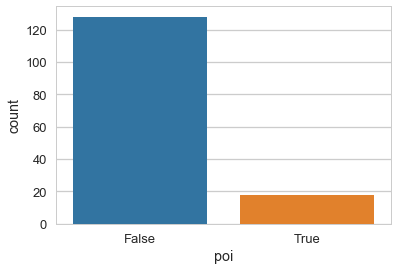

In [7]:
sns.set_context("talk")
sns.set_style("whitegrid")
sns.despine(left=True)
sns.countplot(x='poi',data=eron_data) 

Lets treat our missing data. In order to do so we will need to first see how many NaN are on our dataset by each feature.

In [8]:
def PercentageMissin(Dataset):
    """this function will return the percentage of missing values in a dataset """
    if isinstance(Dataset,pd.DataFrame):
        adict={} #a dictionary conatin keys columns names and values percentage of missin value in the columns
        for feature in Dataset.columns:
            count_nan_feature = 0;
            for feature_row in Dataset[feature]:
                if(feature_row == 'NaN'):
                    count_nan_feature += 1  
            adict[feature]=(count_nan_feature*100)/len(Dataset[feature])
        return pd.DataFrame(adict,index=['% of missing'],columns=adict.keys())
    else:
        raise TypeError("can only be used with panda dataframe")

In [9]:
print("Ranking of Missing Data")
PercentageMissin(eron_data).mean().sort_values(ascending=False)

Ranking of Missing Data


loan_advances                97.0
director_fees                88.0
restricted_stock_deferred    87.0
deferral_payments            73.0
deferred_income              66.0
long_term_incentive          54.0
bonus                        43.0
from_poi_to_this_person      41.0
from_messages                41.0
shared_receipt_with_poi      41.0
from_this_person_to_poi      41.0
to_messages                  41.0
other                        36.0
expenses                     34.0
salary                       34.0
exercised_stock_options      30.0
restricted_stock             24.0
email_address                23.0
total_payments               14.0
total_stock_value            13.0
poi                           0.0
dtype: float64

First thing that strike my attention was the number of missing data in loan_advances,director_fees, restricted_stock_deferred, deferral_payments. Seems we have just a few of those and I if it wll be usefull to our model.

In [10]:
loan_advances_df = eron_data[eron_data.loan_advances != 'NaN'][['loan_advances','poi']]
print("There are ",len(loan_advances_df)," points in our dataset.")
loan_advances_df

('There are ', 4, ' points in our dataset.')


,loan_advances,poi
FREVERT MARK A,2000000,False
LAY KENNETH L,81525000,True
PICKERING MARK R,400000,False
TOTAL,83925000,False


Since we gae only four poins in our dataset and only one is a poi so I will not consider this from our feature list.

In [11]:
director_fees_df = eron_data[eron_data.director_fees != 'NaN'][['director_fees','poi']]
print("There are ",len(director_fees_df)," points in our dataset.")
director_fees_df

('There are ', 17, ' points in our dataset.')


,director_fees,poi
BELFER ROBERT,3285,False
BHATNAGAR SANJAY,137864,False
BLAKE JR. NORMAN P,113784,False
CHAN RONNIE,98784,False
DUNCAN JOHN H,102492,False
GRAMM WENDY L,119292,False
JAEDICKE ROBERT,108750,False
LEMAISTRE CHARLES,112492,False
MENDELSOHN JOHN,103750,False
MEYER JEROME J,38346,False


From 146 values we have only 17 entries and from those all 17 are false to poi parameter. So I will also not consider in my analysis. 

In [12]:
restricted_stock_deferred_df = eron_data[eron_data.restricted_stock_deferred != 'NaN'][['restricted_stock_deferred','poi']]
print("There are ",len(restricted_stock_deferred_df)," points in our dataset.")
restricted_stock_deferred_df

('There are ', 18, ' points in our dataset.')


,restricted_stock_deferred,poi
ALLEN PHILLIP K,-126027,False
BANNANTINE JAMES M,-560222,False
BAY FRANKLIN R,-82782,False
BELFER ROBERT,44093,False
BHATNAGAR SANJAY,15456290,False
CARTER REBECCA C,-307301,False
CHAN RONNIE,-32460,False
CLINE KENNETH W,-472568,False
DERRICK JR. JAMES V,-1787380,False
DETMERING TIMOTHY J,-315068,False


The same happened with restricted_store_deferred as with the director_fee. From 146 values we have only 18 entries and from those all are false to poi parameter. So I will also not consider in my analysis.

In [13]:
deferral_payments_df = eron_data[eron_data.deferral_payments != 'NaN'][['deferral_payments','poi']]
print("There are ",len(deferral_payments_df)," points in our dataset.")
deferral_payments_df

('There are ', 39, ' points in our dataset.')


,deferral_payments,poi
ALLEN PHILLIP K,2869717,False
BADUM JAMES P,178980,False
BAXTER JOHN C,1295738,False
BAY FRANKLIN R,260455,False
BAZELIDES PHILIP J,684694,False
BELDEN TIMOTHY N,2144013,True
BELFER ROBERT,-102500,False
BUY RICHARD B,649584,False
COLWELL WESLEY,27610,True
DETMERING TIMOTHY J,875307,False


In [14]:
deferral_payments_df.groupby('poi').count()

,deferral_payments
poi,
False,34
True,5


We found some poi in deferral payments!! There were 5 poi out of 39 people in this feature. Let see  if plotting the values we found some more information about this points.

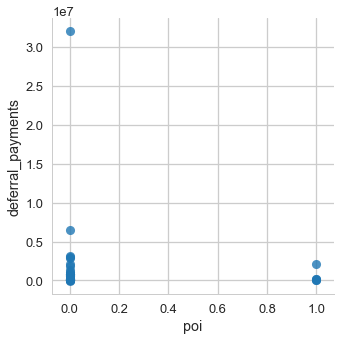

In [15]:
sns.lmplot('poi','deferral_payments',data=deferral_payments_df,fit_reg=False)

In [16]:
deferral_payments_df["deferral_payments"].max()

32083396

In [17]:
deferral_payments_df[deferral_payments_df["deferral_payments"] == 32083396]

,deferral_payments,poi
TOTAL,32083396,False


We found that the highest value was he total and it should be an outlier.

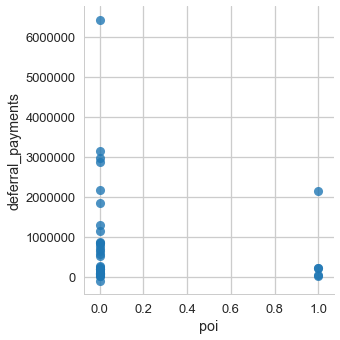

In [18]:
sns.lmplot('poi','deferral_payments',data=deferral_payments_df[deferral_payments_df < 32083396],fit_reg=False)

We also noticed that ther are no much difference between the values of poi and non poi for the deferral payments. Most of the poi felt almost like in the middle of the data.

The others features contain almost 50% of the data so I will use them in my analysis. Other thing is the email_address is unique amoung the people, so I will not use these variable.
The features loan_advances, directors_fees, restricted_stock_deffered and email_address will be use.

### Select Features

In [19]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = [
    'poi','salary', 'to_messages','from_messages', 'from_poi_to_this_person',
    'from_this_person_to_poi', 'deferral_payments', 'other',
    'total_payments','bonus', 'total_stock_value', 'shared_receipt_with_poi', 'long_term_incentive',
    'exercised_stock_options','deferred_income', 'expenses', 'restricted_stock']

# In the featureFormat it will treat the missing values giving them a 0  value
data = featureFormat(data_dict, features_list)

In [20]:
eron_data = eron_data.replace('NaN', 0)

### Outliers

In this part we will find the outliers and remove them.

In [21]:
### Task 2: Remove outliers
persons_name = ""
most_money = 0

for name in data_dict.keys():
    person = data_dict[name]
    if(data_dict[name]['total_payments'] != 'NaN' and data_dict[name]['total_payments'] > most_money):
        persons_name = name;
        most_money = data_dict[name]['total_payments'];
        
print(persons_name, most_money);

('TOTAL', 309886585)


We will use only 2 finacial data. First we will analyze the salary data.

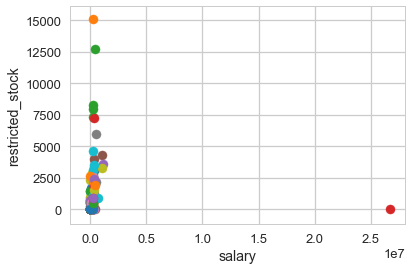

In [22]:
# Salary outlier

outliers = []
for key in data_dict:
    val = data_dict[key]['salary']
    if val == 'NaN':
        continue
    outliers.append((key,int(val)))

for point in data:
    stock = point[2]
    salary = point[1]
    matplotlib.pyplot.scatter( salary, stock )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("restricted_stock")
matplotlib.pyplot.show()

We can see that we have a big outlier in our data set. So lets see what it is.

[('TOTAL', 26704229),
 ('SKILLING JEFFREY K', 1111258),
 ('LAY KENNETH L', 1072321)]


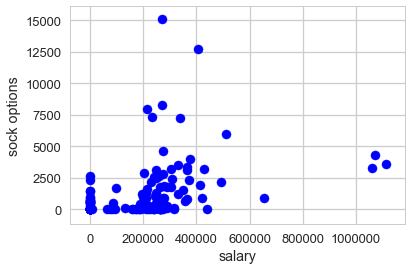

In [23]:
pprint(sorted(outliers,key=lambda x:x[1],reverse=True)[:3])

for point in data:
    stock = point[2]
    salary = point[1]
    if(salary < 26704229):
	    matplotlib.pyplot.scatter( salary, stock,color="b" )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("sock options")
matplotlib.pyplot.show()

We got that our outlier was the TOTAL.And others seem fine.

In [24]:
del data_dict["TOTAL"]

Then lets investigate the restricted_stock.

In [25]:
# investigate Outlier for restricted_stock
outliers = []
for key in data_dict:
    val = data_dict[key]['restricted_stock']
    if val == 'NaN':
        continue
    outliers.append((key,int(val)))
    
pprint(sorted(outliers,key=lambda x:x[1])[:3])
pprint(sorted(outliers,key=lambda x:x[1],reverse=True)[:3])

[('BHATNAGAR SANJAY', -2604490),
 ('CHAN RONNIE', 32460),
 ('JAEDICKE ROBERT', 44093)]
[('LAY KENNETH L', 14761694),
 ('WHITE JR THOMAS E', 13847074),
 ('PAI LOU L', 8453763)]


Seems that we do not have a outlier for restricted stock.

#### Question: 
Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

#### Answer:

The goal of this project is to succesfully identify the POIs of the Eron scandal. In order to do it I will use machine learning classify algorithm, that can throught the data identify patterns of the POI. In this project I will use the dataset contaning some financial data and  email data.

### Optimize Feature Selection/Engineering:
- Create new features (related lesson: "Feature Selection"): 

At least one new feature is implemented. Justification for that feature is provided in the written response. The effect of that feature on final algorithm performance is tested or its strength is compared to other features in feature selection. The student is not required to include their new feature in their final feature set.

- Intelligently select features (related lesson: "Feature Selection"):

Univariate or recursive feature selection is deployed, or features are selected by hand (different combinations of features are attempted, and the performance is documented for each one). Features that are selected are reported and the number of features selected is justified. For an algorithm that supports getting the feature importances (e.g. decision tree) or feature scores (e.g. SelectKBest), those are documented as well.

- Properly scale features (related lesson: "Feature Scaling")

If algorithm calls for scaled features, feature scaling is deployed.
   

###### Creating new features

In [26]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict


In [27]:
eron_data[eron_data['to_messages'] < eron_data['from_poi_to_this_person']][['from_poi_to_this_person', 'to_messages']]

,from_poi_to_this_person,to_messages


In [28]:
eron_data[eron_data['from_messages'] < eron_data['from_this_person_to_poi']][['from_this_person_to_poi', 'from_messages']]

,from_this_person_to_poi,from_messages


In [29]:
from __future__ import division
# 'to_messages', 'from_messages', 'shared_receipt_with_poi', 'from_this_person_to_poi', 'from_poi_to_this_person'
def compute_fraction_poi_total_messages(poi_messages, total_messages):
    fraction_messages = 0.
    
    if(poi_messages !='NaN' and total_messages != 'NaN'):
        fraction_messages = poi_messages/total_messages
    
    return fraction_messages

def compute_fraction_from_poi_to_person(person_data):

    qtd_messages_total = person_data['to_messages']
    qtd_messages_from_poi = person_data['from_poi_to_this_person']
    fraction_messages_from_poi = compute_fraction_poi_total_messages(qtd_messages_from_poi,qtd_messages_total)
    
    return fraction_messages_from_poi

def compute_fraction_from_person_to_poi(person_data):
    
    qtd_messages_to_total = person_data['from_messages']
    qtd_messages_to_poi = person_data['from_this_person_to_poi']
    fraction_messages_to_poi = compute_fraction_poi_total_messages( qtd_messages_to_poi, qtd_messages_to_total)
    
    return fraction_messages_to_poi


In [30]:
# Engineer a new feature


for person_name in my_dataset:
    person_data = my_dataset[person_name]
    person_data["fraction_messages_from_poi"] = compute_fraction_from_poi_to_person(person_data);
    person_data["fraction_messages_to_poi"] = compute_fraction_from_person_to_poi(person_data);
    print(person_data["fraction_messages_from_poi"],person_data["fraction_messages_to_poi"])
    


(0.04708798017348203, 0.034482758620689655)
(0.0, 0.0)
(0.0, 0.0)
(0.013089005235602094, 0.0)
(0.03062200956937799, 0.65625)
(0.0, 0.0)
(0.0, 0.0)
(0.024628450106157114, 0.5416666666666666)
(0.01872340425531915, 0.013979496738117428)
(0.049273021001615507, 0.21621621621621623)
(0.078125, 1.0)
(0.10810810810810811, 0.0)
(0.010101010101010102, 0.14285714285714285)
(0.013978088401964487, 0.34210526315789475)
(0.0, 0.0)
(0.0, 0.0)
(0.13651877133105803, 0.275)
(0.08823529411764706, 0.0)
(0.09689922480620156, 0.3392857142857143)
(0.0, 0.0)
(0.0, 0.0)
(0.02533532041728763, 0.0)
(0.030222757375075255, 0.11226851851851852)
(0.0, 0.0)
(0.0, 0.0)
(0.029183483390251473, 0.030958597538232)
(0.0, 0.0)
(0.010443864229765013, 0.0)
(0.0, 0.0)
(0.01431238332296204, 0.2)
(0.02635542168674699, 0.5853658536585366)
(0.0, 0.0)
(0.01968557758031442, 0.08887865530739121)
(0.006980802792321117, 0.3684210526315789)
(0.0, 0.0)
(0.0, 0.0)
(0.030303030303030304, 0.037037037037037035)
(0.0, 0.0)
(0.01050420168067227

In [31]:
print(my_dataset['BANNANTINE JAMES M'])

{'to_messages': 566, 'fraction_messages_from_poi': 0.06890459363957598, 'deferral_payments': 'NaN', 'expenses': 56301, 'fraction_messages_to_poi': 0.0, 'poi': False, 'deferred_income': -5104, 'email_address': 'james.bannantine@enron.com', 'long_term_incentive': 'NaN', 'restricted_stock_deferred': -560222, 'shared_receipt_with_poi': 465, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 864523, 'director_fees': 'NaN', 'bonus': 'NaN', 'total_stock_value': 5243487, 'from_poi_to_this_person': 39, 'from_this_person_to_poi': 0, 'restricted_stock': 1757552, 'salary': 477, 'total_payments': 916197, 'exercised_stock_options': 4046157}


In [32]:
new_features = ["fraction_messages_from_poi","fraction_messages_to_poi"]

for feature_name in new_features:
    if feature_name  not in features_list:
        features_list.append(feature_name)

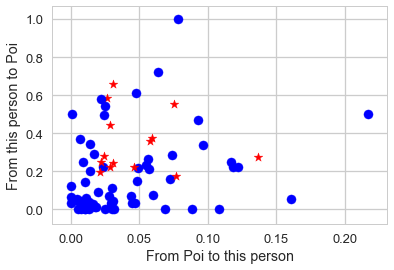

In [33]:
### plot new features
fraction_list = ['poi','fraction_messages_from_poi','fraction_messages_to_poi']
data_fraction = featureFormat(my_dataset,fraction_list)
for point in data_fraction:
    from_point = point[1]
    to_point = point[2]
    if point[0] == 1:
        plt.scatter(from_point,to_point,color="r",marker="*")
    else:
        plt.scatter(from_point, to_point,color="b")
plt.ylabel("From this person to Poi")
plt.xlabel('From Poi to this person')
plt.show()

##### Feature selection

In [34]:
# features_list = ['poi','salary', 'restricted_stock','bonus', 
#                  'total_payments', 'total_stock_value','expenses',
#                  'fraction_messages_from_poi','fraction_messages_to_poi','from_this_person_to_poi', 'from_poi_to_this_person']

In [35]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
print("Initial data shape:", data.shape)
print("Feature_list:", features_list)

('Initial data shape:', (144, 19))
('Feature_list:', ['poi', 'salary', 'to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'deferral_payments', 'other', 'total_payments', 'bonus', 'total_stock_value', 'shared_receipt_with_poi', 'long_term_incentive', 'exercised_stock_options', 'deferred_income', 'expenses', 'restricted_stock', 'fraction_messages_from_poi', 'fraction_messages_to_poi'])


In [36]:
features = np.array(features)

data.shape,features.shape

((144, 19), (144, 18))

In [37]:
import numpy as np
import pandas as pd 
data_pd = pd.DataFrame(data=data)
corr = data_pd.corr()

In [38]:
corr.shape

(19, 19)

In [39]:
# Feature selection - selectionkbest, select percentile,lasso regression
from sklearn.feature_selection import SelectPercentile,SelectKBest,chi2

selector = SelectKBest(k=10)
new_data = selector.fit_transform(features,labels)
scores_KB = selector.scores_

print("Final shape of parameters",new_data.shape)
print("Feature scores:",selector.scores_)
                                                                                                                                                                                                                   

('Final shape of parameters', (144, 10))
('Feature scores:', array([ 18.57570327,   1.69882435,   0.1641645 ,   5.34494152,
         2.42650813,   0.21705893,   4.20497086,   8.86672154,
        21.06000171,  24.46765405,   8.74648553,  10.07245453,
        25.09754153,  11.59554766,   6.23420114,   9.34670079,
         3.21076192,  16.64170707]))


In [40]:
import numpy as np

scores = selector.scores_
print(scores)
indices = np.argsort(scores)[::-1]
print(indices)
print 'Feature Ranking'
for i in range(len(scores)-1): 
    print "{} feature {} ({})".format(i+1,features_list[indices[i]+1],scores[indices[i]])

[ 18.57570327   1.69882435   0.1641645    5.34494152   2.42650813
   0.21705893   4.20497086   8.86672154  21.06000171  24.46765405
   8.74648553  10.07245453  25.09754153  11.59554766   6.23420114
   9.34670079   3.21076192  16.64170707]
[12  9  8  0 17 13 11 15  7 10 14  3  6 16  4  1  5  2]
Feature Ranking
1 feature exercised_stock_options (25.0975415287)
2 feature total_stock_value (24.4676540475)
3 feature bonus (21.0600017075)
4 feature salary (18.575703268)
5 feature fraction_messages_to_poi (16.6417070705)
6 feature deferred_income (11.5955476597)
7 feature long_term_incentive (10.0724545294)
8 feature restricted_stock (9.34670079105)
9 feature total_payments (8.86672153711)
10 feature shared_receipt_with_poi (8.74648553213)
11 feature expenses (6.23420114051)
12 feature from_poi_to_this_person (5.34494152315)
13 feature other (4.2049708583)
14 feature fraction_messages_from_poi (3.21076191697)
15 feature from_this_person_to_poi (2.42650812724)
16 feature to_messages (1.6988243

I used SelectBestK with k = 3. Then I stayed with the top 3 features: ['salary','restricted_stock','bonus']. I also noticed that they all are financial data. With them I got in a DecisionTree an accuracy of 0.83, a recall of 0.44 and a precision of 0.8.


#### Feature scaling

In [41]:
# from sklearn.decomposition import PCA
# #Pca
# pca = PCA(n_components=2)
# features = pca.fit_transform(new_data)

In [42]:
# Feature scalling for restricted stock
# from sklearn.preprocessing import StandardScaler

# def standarlize_matrix(arr):
#     standardScaler = StandardScaler()
#     arr_standerized = standardScaler.fit_transform(arr)
#     return arr;

# data = featureFormat(my_dataset, features_list, sort_keys = True)

# new_data = standarlize_matrix(data);

In [43]:
# line = 0
# for row in my_dataset:
#     i = 0;
#     for feature in features_list:
#         if(line < len(new_data)):
#             my_dataset[row][feature] = new_data[line][i]
#         i += 1;
#     line += 1

I tried two types of feature scalling: min-max (normalization) and also standalization. I notice that with min-max my accuracy went worse than without feature scalling. Then I tried standardlization and it performed better than without it improving our accuracy from 0.83 to near 0.86. In my opinion, it is due to the way that min-max treats outliers.

#### Question: 
What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]


#### Answer

I end up using in my POI identifier the features 'poi', 'salary', 'restricted_stock', 'bonus', 'total_payments', 'total_stock_value' to select them I used the SelectKBest and I end up latter scalling them in oder to to standarlize the features. I created two new variables fraction of emails received from POI and fraction of emails sent to poi. I noticed that the features that helped me to identify poi were the financial features.  

## Pick an Algorithm

- Pick an algorithm (related lessons: "Naive Bayes" through "Choose Your Own Algorithm")

At least two different algorithms are attempted and their performance is compared, with the best performing one used in the final analysis.


Let's first separate between train and test data set.

In [44]:
my_data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(my_data)

# Train and test
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [45]:
#Function that will help to compute metrics.
from sklearn.metrics import accuracy_score,precision_score,recall_score

def compute_metrics(predict,labels_test):

    accuracy = accuracy_score(predict,labels_test);
    recall = recall_score(predict,labels_test);
    precision = precision_score(predict,labels_test);

    print "Accuracy Score: {}%".format(accuracy) + " Recall Score: {}%".format(recall) + " Precision Score: {}%".format(precision);

Then we will peak an algorithm.
I will try to fit with:
    - Knn
    - Decision Tree
    - Random Forest
    - Ada Boost

In [46]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(features_train,labels_train)
predict = clf.predict(features_test)
compute_metrics(predict,labels_test);

Accuracy Score: 0.863636363636% Recall Score: 0.4% Precision Score: 0.4%


In [47]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(features_train,labels_train)
predict = clf.predict(features_test)
compute_metrics(predict,labels_test);

Accuracy Score: 0.909090909091% Recall Score: 0.666666666667% Precision Score: 0.4%


In [48]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)

predict = clf.predict(features_test)

In [49]:
compute_metrics(predict,labels_test);
print(predict,labels_test);

Accuracy Score: 0.772727272727% Recall Score: 0.0% Precision Score: 0.0%
(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])


In [50]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=110)
clf.fit(features_train,labels_train)
predict = clf.predict(features_test)
compute_metrics(predict,labels_test);

Accuracy Score: 0.840909090909% Recall Score: 0.25% Precision Score: 0.2%


In [51]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(features_train,labels_train)
predict = clf.predict(features_test)
compute_metrics(predict,labels_test);

Accuracy Score: 0.909090909091% Recall Score: 1.0% Precision Score: 0.2%


#### Question:
What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

#### Answer:

I tried to use knn, naive bayes, decision trees and some ensembles classifiers like adaboost and random forest. I noticed that with knn. I had a better accuracy so I picked as my final algorithm.

## Tune an Algorithm

- Discuss parameter tuning and its importance.:

Response addresses what it means to perform parameter tuning and why it is important.

- Tune the algorithm (related lesson: "Validation"):

At least one important parameter tuned with at least 3 settings investigated systematically, or any of the following are true:

GridSearchCV used for parameter tuning
Several parameters tuned
Parameter tuning incorporated into algorithm selection (i.e. parameters tuned for more than one algorithm, and best algorithm-tune combination selected for final analysis).


- Algorithm Performance

When tester.py is used to evaluate performance, precision and recall are both at least 0.3.

- Validation Strategy (related lesson "Validation")

Performance of the final algorithm selected is assessed by splitting the data into training and testing sets or through the use of cross validation, noting the specific type of validation performed. 


In [52]:
from sklearn.model_selection import StratifiedKFold,GridSearchCV

def init_cross_validation(train_reduced, labels):
    
    cross_validation = StratifiedKFold(n_splits=3)
    cross_validation.get_n_splits(train_reduced, labels)
    
    return cross_validation;

def generate_grid_search_model(model,parameters,train_reduced,labels):
    
    cross_validation = init_cross_validation(train_reduced, labels);
    
    grid_search = GridSearchCV(model,
                               scoring='accuracy',
                               param_grid = parameters,
                               cv = cross_validation)

    grid_search.fit(train_reduced, labels)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
    return model

In [53]:
def create_KNeighbors(train_reduced,labels,run_grid_search=False):
    
    if run_grid_search:
        
        parameter_grid = {
            'n_neighbors' : [3,4,5],
            'weights' : ['distance','uniform'],
            'leaf_size':[30,40],
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1,2,3]
        }
        clf =  KNeighborsClassifier()
        clf = generate_grid_search_model(clf,parameter_grid,train_reduced,labels)
    else: 
        parameters = {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 30, 'algorithm': 'auto', 'p': 2}
        clf = KNeighborsClassifier(**parameters)
        clf.fit(train_reduced, labels)

    return clf

In [54]:
def create_random_forest(train_reduced,labels,run_grid_search=False):
    
    if run_grid_search:
        
        parameter_grid = {
            'max_depth' : [4, 6, 8],
            'n_estimators': [50,100],
            'max_features': ['sqrt', 'auto', 'log2'],
            'min_samples_split': [3, 10],
            'min_samples_leaf': [1, 3, 10],
            'bootstrap': [True, False],
        }
        clf = RandomForestClassifier()
        clf = generate_grid_search_model(clf,parameter_grid,train_reduced,labels)
    else: 
        parameters = {
            'bootstrap': False, 'min_samples_leaf': 1, 
            'n_estimators': 50, 'min_samples_split': 3, 
            'max_features': 'sqrt', 'max_depth': 4
        }

        clf = RandomForestClassifier(**parameters)
        clf.fit(train_reduced, labels)

    return clf

In [55]:
def create_AdaBoost(train_reduced,labels,run_grid_search=False):
    
    if run_grid_search:
        
        parameter_grid = {
            'n_estimators': [100,110,120,130]
        }
        clf = AdaBoostClassifier()
        clf = generate_grid_search_model(clf,parameter_grid,train_reduced,labels)
    else: 
        parameters = {
            'n_estimators': 130
        }

        clf = AdaBoostClassifier(**parameters)
        clf.fit(train_reduced, labels)

    return clf

In [65]:
#clf =  create_KNeighbors(features,labels,run_grid_search=False)
clf =  create_random_forest(features,labels,run_grid_search=False)

In [ ]:
clf = create_AdaBoost(features,labels,run_grid_search=True)

Best score: 0.854166666667
Best parameters: {'n_estimators': 130}


In [61]:
clf = GaussianNB()

#### Question
What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

#### Answer:

Tuning the algorithm means finding the best parameters for a certain model, that gives a better results. 
I tuned my particular algorithm with GridSearchCV. For my Adaboost model I tuned the n_estimators. And the final result was 

### Validate and Evaluate
- Usage of Evaluation Metrics (related lesson: "Evaluation Metrics")
	
At least two appropriate metrics are used to evaluate algorithm performance (e.g. precision and recall), and the student articulates what those metrics measure in context of the project task.

- Discuss validation and its importance.

Response addresses what validation is and why it is important.


Evaluate

In [58]:
predict = clf.predict(features_test)
compute_metrics(predict,labels_test);

Accuracy Score: 1.0% Recall Score: 1.0% Precision Score: 1.0%


In [ ]:
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

#### Question
What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]

#### Answer:

Validation process is when you divided your dataset into train, test datasets. A classic mistake is to not divide into these to dataset and use the entire data to train your model. I validade my model using a croess-validation (that means dividing my dataset into small chucks and using most of them to train and a chuck to test and then repeat the process).To validate my model I used a  k-fold = 5.

#### Question: 

Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

#### Answer:

And also to validate I used the accuracy, reacall and prediction socer. In my final model I got Accuracy Score: 100% Recall Score: 100% Precision Score: 100%.

## Exporting Model

In [ ]:

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.


dump_classifier_and_data(clf, my_dataset, features_list)